# Evaluate the question matcher using the existing harmonisation tool as a gold standard



In [1]:
import sys

sys.path.append("../front_end")


import bz2
import os
import pickle as pkl
import re
import sys
from nltk.corpus import stopwords
from langdetect import detect
import numpy as np

import pandas as pd

from utils.pt_en_dict import pt_en_map
from utils.spacy_wrapper import get_spacy_model


In [2]:
INPUT_FILE = "../data/Final harmonised item tool EM.xlsx"


In [3]:
initial_number_regex = re.compile(r'^\d+\.')

In [4]:
question_to_category_for_gold_standard = {}

# TODO: do Adulthood separately
question_dfs = []
for sheet_name in ("Childhood",):
    df = pd.read_excel(INPUT_FILE, sheet_name=sheet_name)

    if sheet_name == "Adulthood":
        labels_in_this_sheet = ["Adulthood"] * len(df)
        df = df[df.columns[4:]]
    else:
        labels_in_this_sheet = list(df["Developmental period"])
        df = df[df.columns[5:]]
        

    for idx in range(0, len(df)):
        if idx > 10:
            break
        questions = {}
        
        q_to_c = {}
        ctr = 0
        
        for j in range(len(df.columns)):
            col_name = df.columns[j]
            text = df[col_name].iloc[idx]
            if type(text) is str and len(text) > 1:
                for q in text.split("/"):
                    q = q.strip()
                    
                    m = initial_number_regex.match(q)
                    if m:
                        number = int(re.sub(r'\.', '', m.group()))
                        questions[number] = initial_number_regex.sub("", q).strip()
                        q_to_c[number] = col_name.strip()
                    elif len(q) > 1:
                        number = ctr
                        questions[number] = q
                        q_to_c[number] = col_name.strip()
                        ctr += 1
        
        if len(questions) > 0:
            question_df = pd.DataFrame({"number":sorted(questions)})
            for j in range(len(question_df)):
                q_no = question_df.number.iloc[j]
                question_to_category_for_gold_standard[(len(question_dfs), j)] = q_to_c[q_no]


            question_df.attrs["language"] = "en"
            question_df["question"] = question_df.number.apply(lambda n : questions[n])
        
        
        
        
            question_dfs.append(question_df)

In [5]:
category_to_question_groups_for_gold_standard = {}
for key, value in question_to_category_for_gold_standard.items():
    category_to_question_groups_for_gold_standard.setdefault(value, [])
    category_to_question_groups_for_gold_standard[value].append(key)

In [6]:
gold_standard = []
for key, groups in category_to_question_groups_for_gold_standard.items():
    if len(groups) > 1:
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                gold_standard.append((groups[i][0], groups[i][1], groups[j][0], groups[j][1]))

In [7]:
gold_standard_dict = {}
for i in range(len(question_dfs)):
    for idx in range(len(question_dfs[i])):
        for j in range(i + 1, len(question_dfs)):
            for jdx in range(len(question_dfs[j])):
                gold_standard_dict[(i, idx, j, jdx)] = 0
for g in gold_standard:
    gold_standard_dict[g] = 1

In [8]:
len(gold_standard_dict)

30007

In [9]:
len(question_dfs)

11

In [10]:
from utils.question_matcher_transformer_huggingface import QuestionMatcherTransformerHuggingFace

In [11]:
qm = QuestionMatcherTransformerHuggingFace()

In [12]:
matches = qm.match_questions(question_dfs)

In [13]:
matches_pruned = [m for m in matches if matches[m] > 0.5]

print ("Number of matches found", len(set(matches_pruned)))
print ("Number of matches in gold standard", len(set(gold_standard)))
print ("Number of matches found which were in gold standard",len(set(matches_pruned).intersection(set(gold_standard))))
print ("Number of matches found which were not in standard",len(set(matches_pruned).difference(set(gold_standard))))

print ("Jaccard", len(set(matches_pruned).intersection(set(gold_standard))) / len(set(matches_pruned).union(set(gold_standard))))

Number of matches found 1166
Number of matches in gold standard 2102
Number of matches found which were in gold standard 594
Number of matches found which were not in standard 572
Jaccard 0.22213911742707554


In [14]:
for m in matches_pruned:
    if m in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Cries Easily = She cries easily
Cries Easily = She gest upset easily
Fights With Other Children = Often fights with other children or bullies them
Bullies Other Children = Often fights with other children or bullies them
Bites or Kicks Other Children = Often fights with other children or bullies them
Worries about Many Things = Has many worries, often seems worried
Will Help Someone who is Hurt = Is helpful if someone is hurt, upset or feeling ill
Is Kind to Young Children = Is kind to younger children
Is Considerate for Others = Is considerate of other people's feelings
Is Afraid of New Things = Has many fears, is easily scared
Is Restless and Doesnt keep still = Is restless, overactive, cannot stay still for long
Other Children Dislike Child = Is generally liked by other children
Other Children Dislike Child = Is picked on or bullied by other children
Gets on With Other Children = Is generally liked by other children
Gets on With Other Children = Is picked on or bullied by other chil

In [15]:
for m in matches_pruned:
    if m not in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Shares Treats With Friends = She makes friends easily
Gives Up Easily = She gest upset easily
Has Speech Difficulty = She gest upset easily
Fights With Other Children = Shares readily with other children (treats, toys, pencils etc)
Fights With Other Children = Is generally liked by other children
Fights With Other Children = Is picked on or bullied by other children
Fights With Other Children = Gets on better with adults than with other children
Bullies Other Children = Is generally liked by other children
Bullies Other Children = Is picked on or bullied by other children
Bites or Kicks Other Children = Is picked on or bullied by other children
Is Inconsiderate of Others = Is considerate of other people's feelings
Worries about Many Things = Has many fears, is easily scared
Shares Treats With Friends = Has at least one good friends
Other Children Dislike Child = Gets on better with adults than with other children
Gets on With Other Children = Shares readily with other children (treats,

Has many fears, is easily scared = Worries about many things
Often has temper tantrums or hot tempers = Is constantly fidgeting or squirming
Often has temper tantrums or hot tempers = Is often unhappy, down hearted or tearful
Has many worries, often seems worried = Has many fears, is easily scared
Is constantly fidgeting or squirming = Often has temper tantrums or hot tempers
Often fights with other children or bullies them = Is picked on or bullied by other children
Is often unhappy, down hearted or tearful = Often has temper tantrums or hot tempers
Is often unhappy, down hearted or tearful = Often lies or cheats
Is generally liked by other children = Is kind to younger children
Is generally liked by other children = Gets on better with adults than with other children
Is kind to younger children = Is generally liked by other children
Often lies or cheats = Is often unhappy, down hearted or tearful
Is picked on or bullied by other children = Often fights with other children or bullies 

In [16]:
for m in gold_standard:
    if m not in matches:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Fights With Other Children = Bullies Other Children
Fights With Other Children = Bites or Kicks Other Children
Bullies Other Children = Bites or Kicks Other Children
Frequently fights other children = Bullies other children
Child fights with other children = Child bullies other children
Child fights with other children = Child bullies other children
Is Disobedient = Is Inconsiderate of Others
Is generally obedient, usually does what adults request = Often argumentative with adults
Tells Lies = Blames Other for Things
Tries to be Fair in Games = Is Affectionate to Family Members
Tri

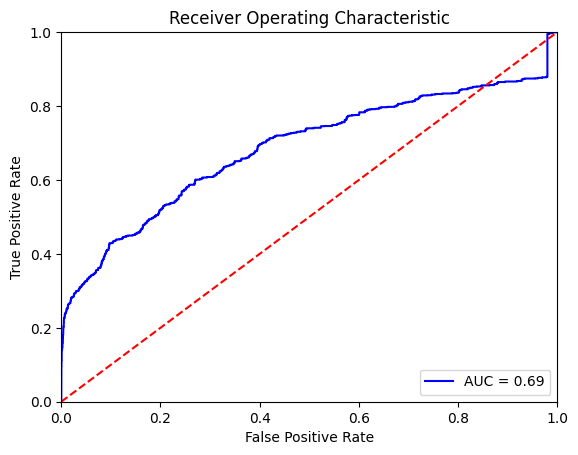

In [17]:
import sklearn.metrics as metrics

y_pred = []
y_test = []
for m, g in gold_standard_dict.items():
    y_pred.append(matches.get(m, 0))
    y_test.append(g)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
print ("FALSE NEGATIVES")

import operator 
all_positives = [m for m in gold_standard_dict if gold_standard_dict[m] == 1 ]
estimated_values_for_gt_1 = dict([(m, matches.get(m, 0)) for m in all_positives])

for m, v in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1)):
    print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]], v)

FALSE NEGATIVES
Is Inattentive = Cannot settle to anything for more than a few moments. -0.0613982230424881
Is Squirmy and Fidgety = Child cannot settle to do anything for more than a few moments -0.01846226677298546
Is Squirmy and Fidgety = Child cannot settle to do anything for more than a few moments -0.01846226677298546
Tries to Stop Quarrels = Often volunteers to help others (parents, teachers, other children) -0.012740882113575935
Tries to Stop Quarrels = Often volunteers to help others (parents, teachers, other children) -0.012740882113575935
Tries to Stop Quarrels = Often volunteers to help others (parents, teachers, other children) -0.012740882113575935
Is squirmy or fidgety = Child cannot settle to do anything for more than a few moments -0.0051843635737895966
Is squirmy or fidgety = Child cannot settle to do anything for more than a few moments -0.0051843635737895966
Child cannot settle to do anything for more than a few moments = Is squirmy or fidgety -0.0051843635737895966

In [19]:
print ("FALSE POSITIVES")

import operator 
all_negatives = [m for m in gold_standard_dict if gold_standard_dict[m] == 0 ]
estimated_values_for_gt_0 = dict([(m, matches.get(m, 0)) for m in all_negatives])

for m, v in sorted(estimated_values_for_gt_0.items(), key=operator.itemgetter(1), reverse=True):
    print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]], v)

FALSE POSITIVES
Gets on With Other Children = Fights with other children 0.8854992985725403
Other Children Dislike Child = Child bullies other children 0.8017560243606567
Other Children Dislike Child = Child bullies other children 0.8017560243606567
Child bullies other children = Is bullied by other children 0.7982100248336792
Child bullies other children = Is bullied by other children 0.7982100248336792
Other Children Dislike Child = Bullies other children 0.7879873514175415
Bullies other children = Is bullied by other children 0.7878777384757996
Gets on With Other Children = Child fights with other children 0.7872906923294067
Gets on With Other Children = Child fights with other children 0.7872906923294067
Bullies Other Children = Is bullied by other children 0.7559332847595215
Other Children Dislike Child = Fights with other children 0.7435920834541321
Gets on With Other Children = Child bullies other children 0.7434264421463013
Gets on With Other Children = Child bullies other chil

Often argumentative with adults = Fights with other children 0.3848603367805481
She gest upset easily = Has difficulty in settling to anything for more than a few moments 0.384835422039032
She gest upset easily = Has difficulty in settling to anything for more than a few moments 0.384835422039032
She gest upset easily = Has difficulty in settling to anything for more than a few moments 0.384835422039032
She takes a long time to warm up to strangers = When alone she feels isolated 0.3847724497318268
She takes a long time to warm up to strangers = When alone she feels isolated 0.3847724497318268
When alone she feels isolated = She takes a long time to warm up to strangers 0.3847724497318268
When alone she feels isolated = She takes a long time to warm up to strangers 0.3847724497318268
She takes a long time to warm up to strangers = When alone she feels isolated 0.3847724497318268
When alone she feels isolated = She takes a long time to warm up to strangers 0.3847724497318268
Is kind to 

Child worries about many things = She is very friendly with strangers 0.22383245825767517
She is very friendly with strangers = Child worries about many things 0.22383245825767517
Child worries about many things = She is very friendly with strangers 0.22383245825767517
Has Stutter or Stammer = Is bullied by other children 0.22380945086479187
Is rather solitary, tends to play alone = Is disobedient at home 0.22377729415893555
Is rather solitary, tends to play alone = Is disobedient at home 0.22377729415893555
Is disobedient at home = Is rather solitary, tends to play alone 0.22377729415893555
Child laughs a lot = Child destroys her own things or those belonging to others 0.22372600436210632
Child destroys her own things or those belonging to others = Child laughs a lot 0.22372600436210632
Is Independent, Confident = Child is disobedient 0.22372378408908844
Is Independent, Confident = Child is disobedient 0.22372378408908844
Is Forceful and Determined = She gest upset easily 0.2237170636

She is very friendly with strangers = Is irritable, quick to fly off the handle 0.21803787350654602
She is always on the go = Frequently bites nails or fingers 0.21797598898410797
Frequently bites nails or fingers = She is always on the go 0.21797598898410797
Frequently bites nails or fingers = She is always on the go 0.21797598898410797
Is Affectionate to Family Members = Is generally obedient, usually does what adults request 0.21791315078735352
Is Affectionate to Family Members = Is generally obedient, usually does what adults request 0.21791315078735352
Is Affectionate to Family Members = Is generally obedient, usually does what adults request 0.21791315078735352
Is helpful if someone is hurt, upset or feeling ill = Is constantly fidgeting or squirming 0.2178436815738678
Is helpful if someone is hurt, upset or feeling ill = Is constantly fidgeting or squirming 0.2178436815738678
Is constantly fidgeting or squirming = Is helpful if someone is hurt, upset or feeling ill 0.21784368157

She tends to be somewhat emotional = Destroys own or others' belongings (e.g. tears or breaks) 0.1462385356426239
She prefers quiet inactive games to more active ones = Child is afraid of new things or new situations 0.14622452855110168
She prefers quiet inactive games to more active ones = Child is afraid of new things or new situations 0.14622452855110168
Child is afraid of new things or new situations = She prefers quiet inactive games to more active ones 0.14622452855110168
Child is afraid of new things or new situations = She prefers quiet inactive games to more active ones 0.14622452855110168
She prefers quiet inactive games to more active ones = Child is afraid of new things or new situations 0.14622452855110168
Child is afraid of new things or new situations = She prefers quiet inactive games to more active ones 0.14622452855110168
Is Kind to Young Children = Bites nails 0.14622429013252258
Tells Lies = Has at least one good friends 0.14621427655220032
Tells Lies = Has at least

She makes friends easily = Often has temper tantrums or hot tempers 0.1285831332206726
Child is afraid of new things or new situations = her own rather than with others 0.1285499930381775
Child is afraid of new things or new situations = her own rather than with others 0.1285499930381775
Frequently fights other children = Is irritable, quick to fly off the handle 0.1285419911146164
Is Independent, Confident = Is bullied by other children 0.12851925194263458
Is Inattentive = She makes friends easily 0.12850213050842285
Is Inattentive = She makes friends easily 0.12850213050842285
Is Inattentive = She makes friends easily 0.12850213050842285
Bites Nails or Fingers = Child smiles when child sees their parent(s) 0.12848597764968872
Bites Nails or Fingers = Child smiles when child sees their parent(s) 0.12848597764968872
Helps Round House Voluntary = She is very friendly with strangers 0.12839840352535248
Helps Round House Voluntary = She is very friendly with strangers 0.12839840352535248


Is often disobedient = She prefers playing with other rather than alone 0.08431438356637955
Has Wet Self Past12 MTHs = Frequently fights other children 0.08430412411689758
Tries to Stop Quarrels = She takes a long time to warm up to strangers 0.08429162949323654
Tries to Stop Quarrels = She takes a long time to warm up to strangers 0.08429162949323654
Tries to Stop Quarrels = She takes a long time to warm up to strangers 0.08429162949323654
Frequently bites nails or fingers = Child is not much liked by other children 0.08428621292114258
Frequently bites nails or fingers = Child is not much liked by other children 0.08428621292114258
Is Independent, Confident = She prefers quiet inactive games to more active ones 0.08427757024765015
Is Independent, Confident = She prefers quiet inactive games to more active ones 0.08427757024765015
Is Independent, Confident = She prefers quiet inactive games to more active ones 0.08427757024765015
Bullies Other Children = Prefers to do things on his 0.0

Tries to Stop Quarrels = Gets on better with adults than with other children 0.0658416673541069
Is helpful if someone is hurt, upset or feeling ill = Child tells lies 0.065721794962883
Is helpful if someone is hurt, upset or feeling ill = Child tells lies 0.065721794962883
Child tells lies = Is helpful if someone is hurt, upset or feeling ill 0.065721794962883
Child tells lies = Is helpful if someone is hurt, upset or feeling ill 0.065721794962883
Is helpful if someone is hurt, upset or feeling ill = Child tells lies 0.065721794962883
Child tells lies = Is helpful if someone is hurt, upset or feeling ill 0.065721794962883
Blames Other for Things = She prefers quiet inactive games to more active ones 0.0657162219285965
Blames Other for Things = She prefers quiet inactive games to more active ones 0.0657162219285965
Blames Other for Things = She prefers quiet inactive games to more active ones 0.0657162219285965
She likes to be with people = Is often unhappy, down hearted or tearful 0.06